In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit, logit, comb
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import os

import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix/utils')
import psix_functions as pr

In [2]:
data_dir = '/mnt/lareaulab/cfbuenabadn/data_sc_regulation/data_autocorrelation/'
tiklova_mrna_event = pd.read_csv(data_dir + 'tiklova_neurogenesis/mrna_per_event.tab', sep='\t', index_col=0)
tiklova_rd = pd.read_csv(data_dir + 'tiklova_neurogenesis/rd_pc2.tab', sep='\t', index_col=0)
tiklova_PSI = pd.read_csv(data_dir + 'tiklova_neurogenesis/skipped_exons_psi.tab', sep='\t', index_col=0)
tiklova_psix = pd.read_csv('~/psix/data/tiklova_neurogenesis/tiklova_neurogenesis.scores.txt', sep='\t', index_col=0)
tiklova_pseudotime = pd.read_csv('~/data_sc_regulation/data_autocorrelation/tiklova_neurogenesis/pseudotime.tab', 
                                 sep='\t', index_col=0)

In [3]:
((tiklova_psix.qvals <= 0.05) & (tiklova_psix.L_score > 0)).sum()

745

In [4]:
745**2

555025

In [4]:
W = pr.get_distance_matrix(tiklova_rd, k=100)

  1%|          | 6/1197 [00:00<00:21, 55.26it/s]

Changed cross function


100%|██████████| 1197/1197 [00:22<00:00, 52.11it/s]


In [5]:
from scipy.special import logit, expit

In [67]:
cadm1_10 = tiklova_PSI.loc['Clta_4']
mapt_1 = tiklova_PSI.loc['Rpn2_3']

blanco_1 = np.array([0 if np.isnan(x) else 1 for x in np.array(cadm1_10)])
blanco_2 = np.array([0 if np.isnan(x) else 1 for x in np.array(mapt_1)])

aver_1 = np.array((W*cadm1_10).sum(axis=1))/np.array(W*blanco_1).sum(axis=1)
aver_2 = np.array((W*mapt_1).sum(axis=1))/np.array(W*blanco_2).sum(axis=1)


In [71]:
exonA = [0.99 if x >= 0.99 else x for x in tiklova_PSI.loc['Clta_4']]
exonA = [0.01 if x <= 0.01 else x for x in exonA]
exonA = logit(np.array(exonA))
exonB = [0.99 if x >= 0.99 else x for x in tiklova_PSI.loc['Rpn2_3']]
exonB = [0.01 if x <= 0.01 else x for x in exonB]
exonB = logit(np.array(exonB))

blanco_1 = np.array([0 if np.isnan(x) else 1 for x in np.array(exonA)])
blanco_2 = np.array([0 if np.isnan(x) else 1 for x in np.array(exonB)])

aver_11 = expit(np.array((W*exonA).sum(axis=1))/np.array(W*blanco_1).sum(axis=1))
aver_21 = expit(np.array((W*exonB).sum(axis=1))/np.array(W*blanco_2).sum(axis=1))


In [6]:
import hotspot

In [8]:
def get_background(psi_table, W, exon_list):
    
    psi_output = pd.DataFrame()
    
    for exon in tqdm(exon_list):

        exon_psi = [0.99 if x >= 0.99 else x for x in psi_table.loc[exon]]
        exon_psi = [0.01 if x <= 0.01 else x for x in exon_psi]
        
        blanco = np.array([0 if np.isnan(x) else 1 for x in np.array(exon_psi)])
        
        background_psi = np.array((W*exon_psi).sum(axis=1))/np.array(W*blanco).sum(axis=1)
        
        psi_output[exon] = background_psi
    
    psi_output.index = psi_table.columns
    return psi_output.T

exon_list = tiklova_psix.loc[(tiklova_psix.L_score > 0) & (tiklova_psix.qvals <= 0.5)].index
background_psi = get_background(tiklova_PSI, W, exon_list)


 24%|██▍       | 284/1170 [03:42<11:29,  1.29it/s]/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
100%|██████████| 1170/1170 [15:42<00:00,  1.24it/s]


(array([145., 335., 244., 186., 105.,  51.,  34.,  35.,  22.,  13.]),
 array([0.05126061, 0.14413455, 0.23700849, 0.32988242, 0.42275636,
        0.5156303 , 0.60850424, 0.70137818, 0.79425212, 0.88712606,
        0.98      ]),
 <a list of 10 Patch objects>)

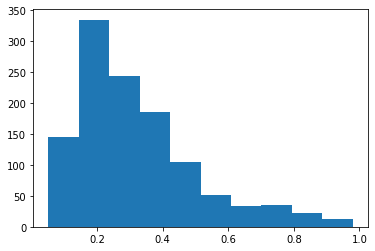

In [13]:
plt.hist(background_psi.quantile(0.95, axis=1) - background_psi.quantile(0.05, axis=1))

(array([ 90., 256., 237., 199., 156.,  82.,  52.,  37.,  36.,  25.]),
 array([0.06101296, 0.15291166, 0.24481036, 0.33670907, 0.42860777,
        0.52050648, 0.61240518, 0.70430389, 0.79620259, 0.8881013 ,
        0.98      ]),
 <a list of 10 Patch objects>)

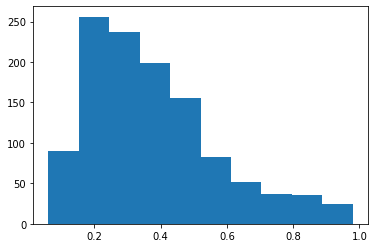

In [14]:
plt.hist(background_psi.quantile(0.99, axis=1) - background_psi.quantile(0.01, axis=1))

In [17]:
np.median(background_psi.quantile(0.99, axis=1) - background_psi.quantile(0.01, axis=1))

0.3386812453735657

In [19]:
np.median(background_psi.max(axis=1) - background_psi.min(axis=1))

0.3857054493165005

In [127]:
background_psi = get_background(tiklova_PSI, W, exon_list)
# background_psi = background_psi.T

 24%|██▍       | 284/1170 [04:11<13:11,  1.12it/s]/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
100%|██████████| 1170/1170 [16:59<00:00,  1.15it/s]


In [10]:
from scipy.stats import zscore
# z_background = pd.DataFrame(zscore(background_psi, nan_policy='omit', axis=1))
# z_background.index = background_psi.index
# z_background.columns = background_psi.columns

In [11]:
z_psi = pd.DataFrame(zscore(tiklova_PSI.loc[exon_list], nan_policy='omit', axis=1))
z_psi.index = exon_list
z_psi.columns = tiklova_PSI.columns

In [160]:

hs = hotspot.Hotspot(z_background.dropna(), model='none', latent=tiklova_rd)
hs.create_knn_graph(weighted_graph=False, n_neighbors=100)
hs_results = hs.compute_autocorrelations()

hs_genes = hs_results.loc[hs_results.FDR < 0.05].index # Select genes

local_correlations = hs.compute_local_correlations(hs_genes, jobs=4) # jobs for parallelization


modules = hs.create_modules(
    min_gene_threshold=30, core_only=True, fdr_threshold=0.05
)

100%|██████████| 1162/1162 [00:00<00:00, 19253.68it/s]


Computing pair-wise local correlation on 1162 features...


100%|██████████| 674541/674541 [00:48<00:00, 13987.76it/s]


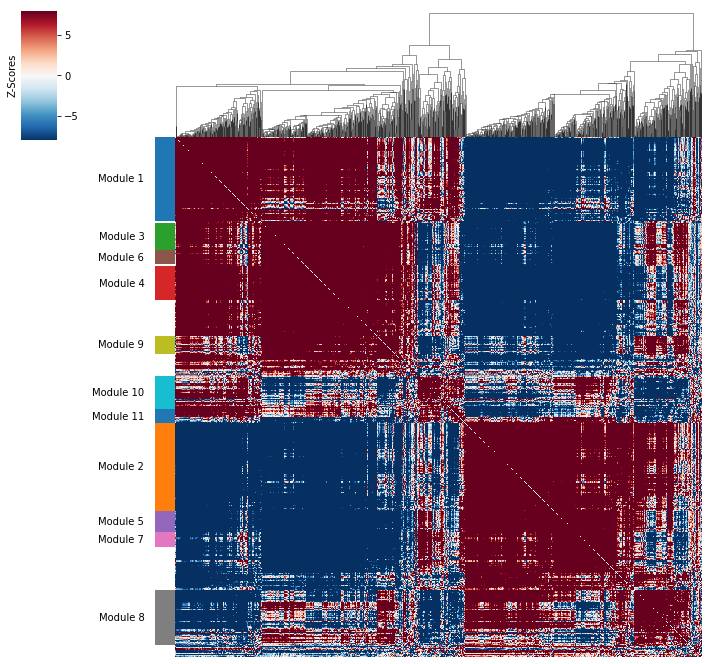

In [162]:
hs.plot_local_correlations()

100%|██████████| 619/619 [00:00<00:00, 13386.93it/s]


Computing pair-wise local correlation on 619 features...


100%|██████████| 191271/191271 [00:25<00:00, 7403.83it/s]


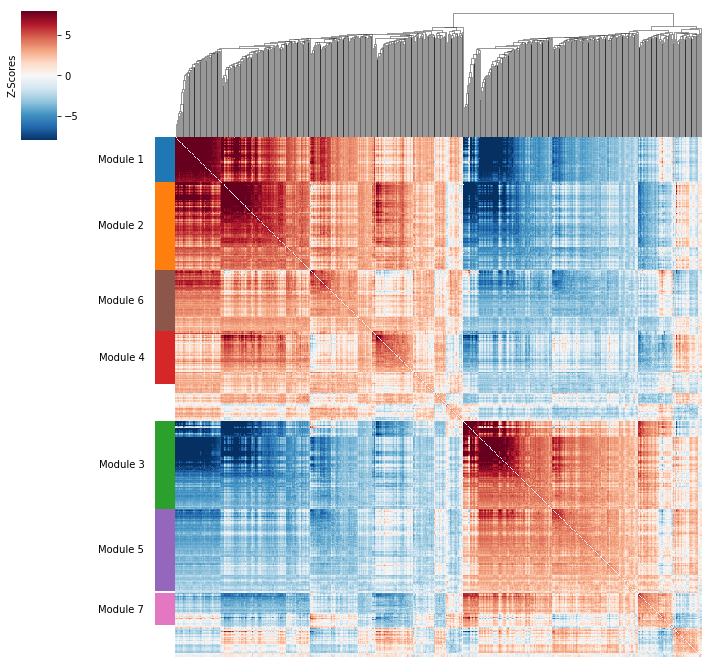

In [12]:

hs = hotspot.Hotspot(z_psi.fillna(0), model='none', latent=tiklova_rd)
hs.create_knn_graph(weighted_graph=False, n_neighbors=100)
hs_results = hs.compute_autocorrelations()

hs_genes = hs_results.loc[hs_results.FDR < 0.05].index # Select genes

local_correlations = hs.compute_local_correlations(hs_genes, jobs=4) # jobs for parallelization


modules = hs.create_modules(
    min_gene_threshold=30, core_only=False, fdr_threshold=0.05
)

hs.plot_local_correlations()

In [ ]:
for exon in hs.modules[hs.modules == 6].index:
    plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc[exon])
    plt.show()

In [15]:
cross_L = pd.read_csv('~/psix/data/tiklova_neurogenesis/tiklova_neurogenesis.cross_scores.tab', sep='\t', index_col=0)

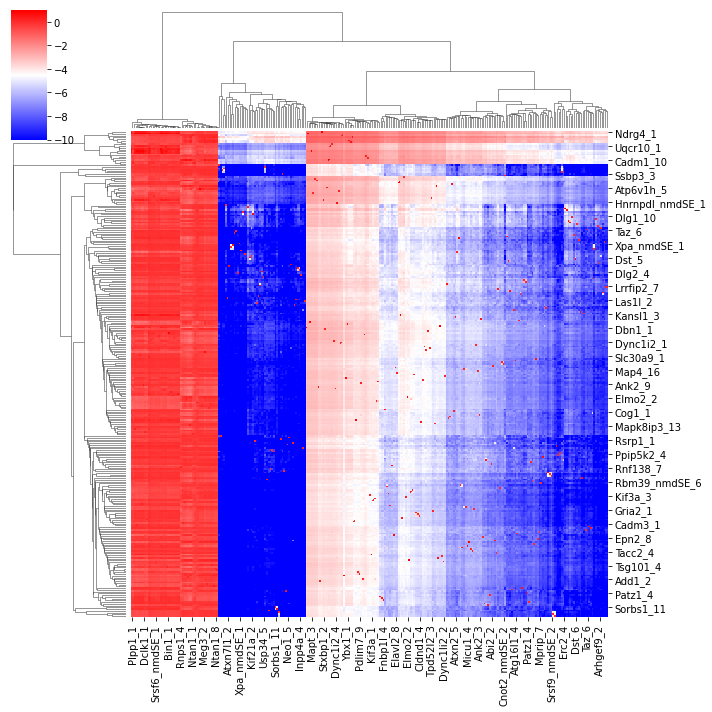

In [18]:
sns.clustermap(cross_L, cmap='bwr', vmin=-10, vmax=1)

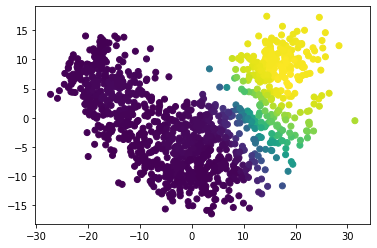

In [176]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=background_psi.loc['Ndrg4_1'])

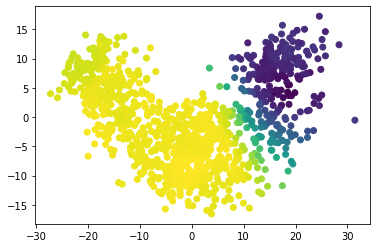

In [113]:
psi_o_array = tiklova_PSI.loc['Cadm1_10'].dropna()
cell_list = psi_o_array.index
psi_o_array = np.array(psi_o_array)

psi_a_array = np.array(
        np.array(pd.DataFrame(
            np.array(W.loc[cell_list, cell_list])*psi_o_array).sum(axis=1)
        )/np.array(W.loc[cell_list, cell_list].sum(axis=1)))

plt.scatter(tiklova_rd.loc[cell_list].PC_1, tiklova_rd.loc[cell_list].PC_2, c=psi_a_array)

In [115]:
spearmanr(background_psi.loc['Cadm1_10', cell_list], psi_a_array)

SpearmanrResult(correlation=0.9986079320029752, pvalue=0.0)

In [123]:
sns

<module 'seaborn' from '/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/seaborn/__init__.py'>

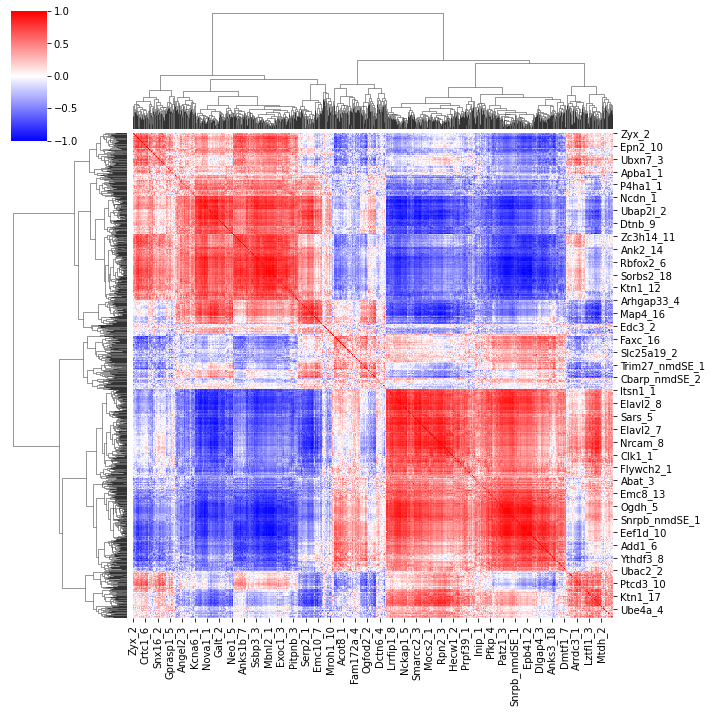

In [126]:
sns.clustermap(background_psi.T.corr(), cmap='bwr', vmin=-1, vmax=1)

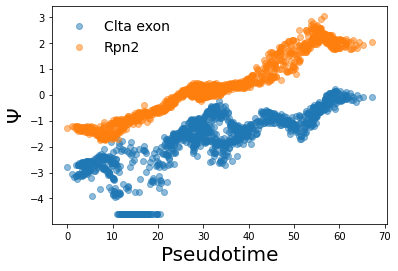

In [134]:
plt.scatter(tiklova_pseudotime.lineage_1_pseudotime, logit(background_psi.loc['Itsn1_1']), alpha=0.5, label='Clta exon')
plt.scatter(tiklova_pseudotime.lineage_1_pseudotime, logit(background_psi.loc['Elavl2_8']), alpha=0.5, label='Rpn2')
# plt.text(50, 0.05, 'Rpn2', fontsize=20)
# plt.text(0, 0.95, 'Clta', fontsize=20)
plt.xlabel('Pseudotime', fontsize=20)
plt.ylabel('$\Psi$', fontsize=20)
plt.legend(frameon=False, fontsize=14)

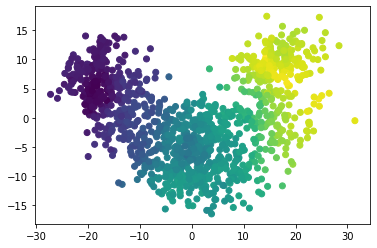

In [139]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=background_psi.loc['Elavl2_8'])

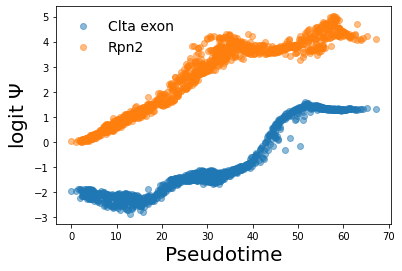

In [48]:
plt.scatter(tiklova_pseudotime.lineage_1_pseudotime, logit(aver_1), alpha=0.5, label='Clta exon')
plt.scatter(tiklova_pseudotime.lineage_1_pseudotime, logit(aver_2), alpha=0.5, label='Rpn2')
# plt.text(50, 0.05, 'Rpn2', fontsize=20)
# plt.text(0, 0.95, 'Clta', fontsize=20)
plt.xlabel('Pseudotime', fontsize=20)
plt.ylabel('logit $\Psi$', fontsize=20)
plt.legend(frameon=False, fontsize=14)

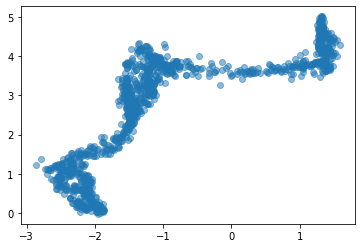

In [40]:
plt.scatter(logit(aver_1), logit(aver_2), alpha=0.5)
# plt.scatter(tiklova_pseudotime.lineage_1_pseudotime, aver_2, alpha=0.5)
# plt.text(50, 0.05, 'Rpn2', fontsize=20)
# plt.text(0, 0.95, 'Clta', fontsize=20)

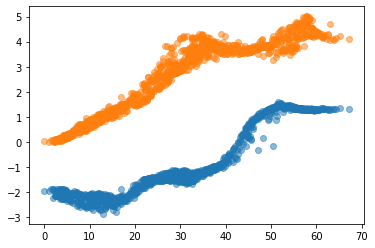

In [35]:
plt.scatter(tiklova_pseudotime.lineage_1_pseudotime, logit(aver_1), alpha=0.5)
plt.scatter(tiklova_pseudotime.lineage_1_pseudotime, logit(aver_2), alpha=0.5)

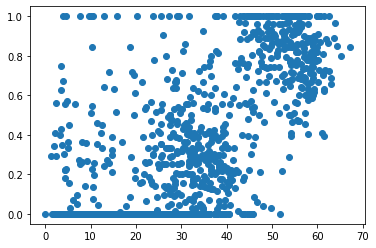

In [38]:
plt.scatter(tiklova_pseudotime.lineage_1_pseudotime,cadm1_10 )

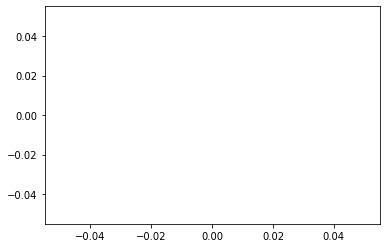

In [111]:
plt.scatter(range(len(aver_1)), logit(aver_1)/(np.std(logit(aver_1))))

In [8]:
logit(aver_2).var()

7.80337720462299

In [14]:
np.std((logit(aver_1) - (np.nanmean(logit(aver_1))-np.nanmean(logit(aver_2))))*a)

2.7934525599377897

In [15]:
np.std(logit(aver_2))

2.7934525599377897

In [10]:
adj = logit(aver_1) - (np.nanmean(logit(aver_1))-np.nanmean(logit(aver_2)))
# adj = 

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until


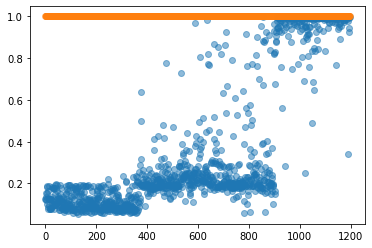

In [6]:

plt.scatter(range(len(aver_2)), expit((logit(aver_2) - np.mean(logit(aver_2)))), alpha=0.5)
a_1 = logit(aver_2).std()/logit(aver_1).std()
plt.scatter(range(len(aver_1)), expit((logit(aver_1) - np.mean(logit(aver_1)))), alpha=0.5)

In [89]:
np.std((logit(aver_2) - np.mean(logit(aver_2)))/np.std(logit(aver_2)))

1.0

24.158536322643766

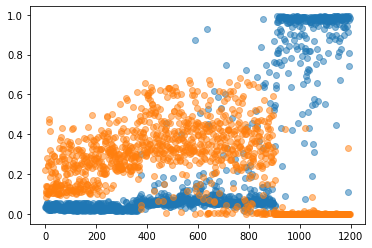

In [12]:
plt.scatter(range(len(aver_2)), aver_2, alpha=0.5)
plt.scatter(range(len(aver_1)), expit((logit(aver_1) - (np.nanmean(logit(aver_1))-np.nanmean(logit(aver_2))))*a), alpha=0.5)

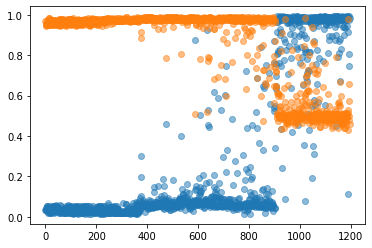

In [18]:
plt.scatter(range(len(aver_2)), aver_2, alpha=0.5)
plt.scatter(range(len(aver_1)), aver_1, alpha=0.5)

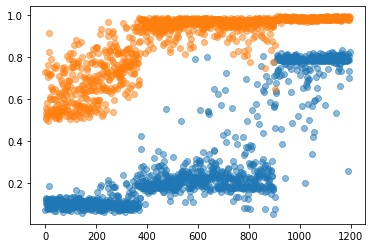

In [28]:
plt.scatter(range(len(aver_2)), aver_2, alpha=0.5)
plt.scatter(range(len(aver_1)), aver_1, alpha=0.5)

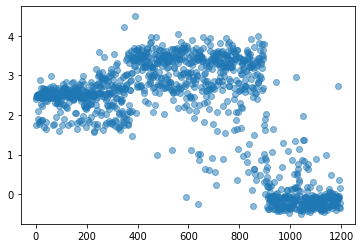

In [13]:
plt.scatter(range(len(aver_1)), logit(aver_2), alpha=0.5)

In [65]:
np.mean(logit(aver_2), np.nanmean()

array([ 0.39167987, -0.30378383, -0.28522002, ...,  3.12047573,
        2.86682924,  3.3943843 ])

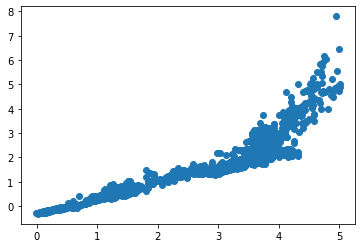

In [62]:
plt.scatter(logit(aver_1), logit(aver_2))

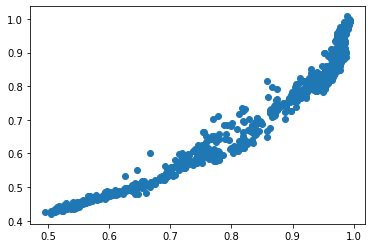

In [59]:
plt.scatter(aver_1, aver_2)

In [41]:
psi_o_array = cadm1_10.dropna()
cell_list = psi_o_array.index
psi_o_array = np.array(psi_o_array)

In [43]:
np.array(W*blanco).sum(axis=1)

array([49.18106766, 55.23191411, 51.97577239, ..., 64.68359363,
       62.41030766, 57.85191912])

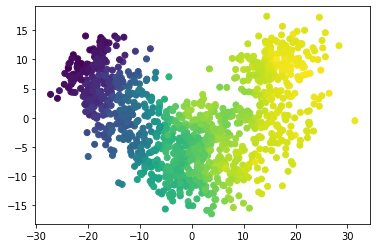

In [52]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=np.array((W*cadm1_10).sum(axis=1))/np.array(W.sum(axis=1)))

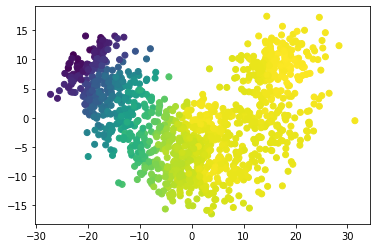

In [53]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=np.array((W*cadm1_10).sum(axis=1))/np.array(W*blanco).sum(axis=1))

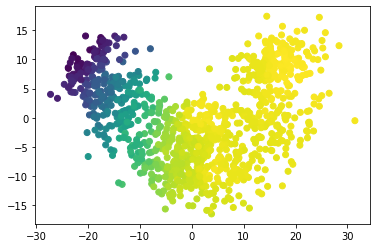

In [51]:
psi_a_array = np.array(
        np.array(pd.DataFrame(
            np.array(W.loc[cell_list, cell_list])*psi_o_array).sum(axis=1)
        )/np.array(W.loc[cell_list, cell_list].sum(axis=1)))

plt.scatter(tiklova_rd.loc[cell_list].PC_1, tiklova_rd.loc[cell_list].PC_2, c=psi_a_array)

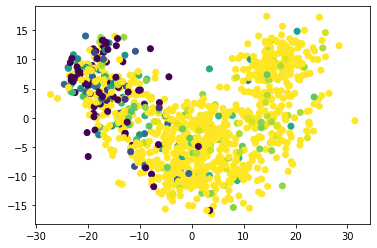

In [46]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Rpn2_3'])

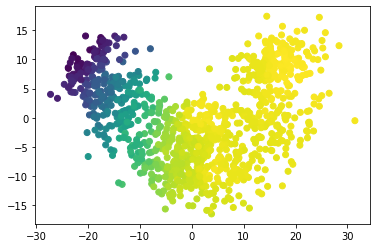

In [54]:
aver = np.array((W*cadm1_10).sum(axis=1))/np.array(W*blanco).sum(axis=1)
np.array([aver[i] for i in range(len(aver)) if not np.isnan(np.array(cadm1_10)[i])])

array([0.72704456, 0.50628493, 0.51562547, ..., 0.97866512, 0.98380475,
       0.98803228])

In [56]:
aver

array([0.72704456, 0.50628493, 0.51562547, ..., 0.97866512, 0.98380475,
       0.98803228])

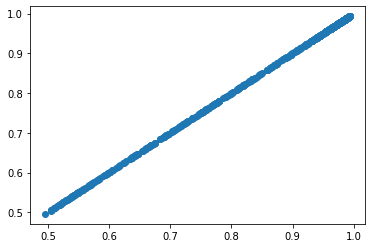

In [55]:
plt.scatter(psi_a_array, np.array([aver[i] for i in range(len(aver)) if not np.isnan(np.array(cadm1_10)[i])]))

In [28]:
pearsonr(psi_a_array, np.array([aver[i] for i in range(len(aver)) if not np.isnan(np.array(cadm1_10)[i])]))

(1.0, 0.0)

In [29]:
spearmanr(psi_a_array, np.array([aver[i] for i in range(len(aver)) if not np.isnan(np.array(cadm1_10)[i])]))

SpearmanrResult(correlation=1.0, pvalue=0.0)

In [153]:
def calculate_cross_L(PSI_tab, W, mrna_counts, exon1, exon2, c = 0.1, 
                      randomize = False, seed=0, min_probability = 0.01, sum_times=10, min_obs=0.25):
    
    try:

        cell_list1 = PSI_tab.loc[exon1].dropna().index
        cell_list2 = PSI_tab.loc[exon2].dropna().index

        cell_list = cell_list1 & cell_list2

        if (len(cell_list1)/len(PSI_tab.columns) < min_obs) or (len(cell_list2)/len(PSI_tab.columns) < min_obs):
            return np.nan, np.nan

        psi_o_array_1 = np.array(PSI_tab.loc[exon1])
        psi_o_array_2 = np.array(PSI_tab.loc[exon2])

        blanco_1 = np.array([0 if np.isnan(x) else 1 for x in psi_o_array_1])
        blanco_2 = np.array([0 if np.isnan(x) else 1 for x in psi_o_array_2])

        mrna_array_1 = np.array([1 if ((x > 0.1) and (x <= 1)) else x for x in mrna_counts.loc[exon1]])
        mrna_array_1 = np.round(mrna_array_1).astype(int)

        mrna_array_2 = np.array([1 if ((x > 0.1) and (x <= 1)) else x for x in mrna_counts.loc[exon2]])
        mrna_array_2 = np.round(mrna_array_2).astype(int)

        total_cells_1 = round((len(cell_list) - np.sum(mrna_array_1 == 0)))
        total_cells_2 = round((len(cell_list) - np.sum(mrna_array_2 == 0)))

        if (total_cells_1 <= 0) or (total_cells_2 <= 0):
            return np.nan, np.nan

#         psi_a_array_1 = np.array((W*psi_o_array_1).sum(axis=1))/np.array(W*blanco_1).sum(axis=1)
#         psi_a_array_2 = np.array((W*psi_o_array_2).sum(axis=1))/np.array(W*blanco_2).sum(axis=1)
        
        psi_a_array_1 = np.array((W*psi_o_array_1).sum(axis=1))/np.array(W*blanco_1).sum(axis=1)
        psi_a_array_2 = np.array((W*psi_o_array_2).sum(axis=1))/np.array(W*blanco_2).sum(axis=1)
        
#         psi_a_array_1_l = logit(psi_a_array_1)
#         psi_a_array_2_l = logit(psi_a_array_2)
        
        a_1 = 1/psi_a_array_1.std()
        a_2 = 1/psi_a_array_2.std()

        psi_a_array_adj_1 = (psi_a_array_1 - (np.nanmean(psi_a_array_1)-np.nanmean(psi_a_array_2)))#*a_1
        psi_a_array_adj_2 = (psi_a_array_2 - (np.nanmean(psi_a_array_2)-np.nanmean(psi_a_array_1)))#*a_2
        
        psi_a_array_adj_1 = [0.99 if x >= 0.99 else x for x in psi_a_array_adj_1]
        psi_a_array_adj_1 = np.array([0.01 if x <= 0.01 else x for x in psi_a_array_adj_1])
        
        psi_a_array_adj_2 = [0.99 if x >= 0.99 else x for x in psi_a_array_adj_2]
        psi_a_array_adj_2 = np.array([0.01 if x <= 0.01 else x for x in psi_a_array_adj_2])
        

#         psi_o_array_1 = [0.99 if x > 0.99 else x for x in psi_o_array_1]
#         psi_o_array_1 = [0.01 if x < 0.01 else x for x in psi_o_array_1]
#         psi_o_array_1 = logit(np.array(psi_o_array_1))
        
#         psi_o_array_2 = [0.99 if x > 0.99 else x for x in psi_o_array_2]
#         psi_o_array_2 = [0.01 if x < 0.01 else x for x in psi_o_array_2]
#         psi_o_array_2 = logit(np.array(psi_o_array_2))
        
        
#         psi_o_array_adj_1 = expit((psi_o_array_1-np.nanmean(psi_o_array_1))/(np.nanstd(psi_o_array_1)))
#         psi_o_array_adj_2 = expit((psi_o_array_2-np.nanmean(psi_o_array_2))/(np.nanstd(psi_o_array_2)))

        psi_null_1 = np.nanmean(psi_o_array_1)
        psi_null_2 = np.nanmean(psi_o_array_2)
        
#         return psi_a_array_1, psi_a_array_adj_1, psi_a_array_2, psi_a_array_adj_2
        
        L_vec_1 = L_statistic_vec(psi_o_array_1, psi_a_array_adj_2, psi_null_1, mrna_array_1, c, min_probability, sum_times)
        L_vec_2 = L_statistic_vec(psi_o_array_2, psi_a_array_adj_1, psi_null_2, mrna_array_2, c, min_probability, sum_times)

#         ######
        return np.sum(L_vec_1)/total_cells_1, np.sum(L_vec_2)/total_cells_2

    except:
        return np.nan, np.nan

In [143]:
v = calculate_cross_L(tiklova_PSI, W, tiklova_mrna_event, "Tecr_6", "Morf4l2_7", c = 0.1, 
                      randomize = False, seed=0, min_probability = 0.01, sum_times=10, min_obs=0.25)

In [141]:
calculate_cross_L(tiklova_PSI, W, tiklova_mrna_event, "Tecr_6", "Morf4l2_7", c = 0.1, 
                      randomize = False, seed=0, min_probability = 0.01, sum_times=10, min_obs=0.25)

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars


(-0.04883712115920566, 0.5466180505223164)

In [138]:
tiklova_psix.sort_values('L_score')[-20:]

,bin,L_score,pvals,qvals,norm_pvals,norm_qvals
Cltb_2,mean_3_var_3,0.906011,0.000999,0.003769,0.0,0.0
Tom1l2_1,mean_2_var_5,0.908341,0.000999,0.003769,0.0,0.0
Dst_6,mean_1_var_5,0.911927,0.000999,0.003769,0.0,0.0
Supt5_5,mean_2_var_5,0.981735,0.000999,0.003769,0.0,0.0
Dlg2_4,mean_1_var_5,0.991318,0.000999,0.003769,0.0,0.0
Kif3a_1,mean_2_var_4,0.996812,0.000999,0.003769,0.0,0.0
Kifap3_1,mean_2_var_4,1.002616,0.000999,0.003769,0.0,0.0
Clta_1,mean_2_var_4,1.016309,0.000999,0.003769,0.0,0.0
Spag9_6,mean_2_var_4,1.019904,0.000999,0.003769,0.0,0.0
Mbnl2_1,mean_2_var_4,1.024391,0.000999,0.003769,0.0,0.0


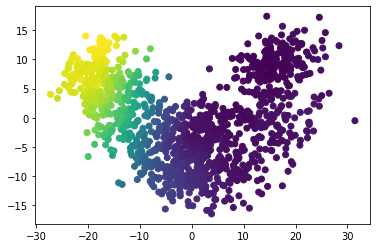

In [140]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=background_psi.loc['Morf4l2_7'])

In [165]:
for exon in hs.modules[hs.modules == 2].index:
    print(exon)
    print(calculate_cross_L(tiklova_PSI, W, tiklova_mrna_event, "Zfp207_1", exon, c = 0.1, 
                      randomize = False, seed=0, min_probability = 0.01, sum_times=10, min_obs=0.25))
    print('###')

Zfp207_1


/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars


(0.6539969198645115, 0.6539969198645115)
###
Cltb_2
(0.7203449426187791, 0.47252309169716816)
###
G3bp2_4
(0.4386477367957721, 0.4257950734985091)
###
Rpn2_3
(0.5906455072665028, 0.5185479134738357)
###
Arfgap1_7
(1.15343830493815, 0.20485584218512898)
###
Mff_8
(0.5078769587966729, 0.48726575291020424)
###
Clta_1
(0.8351423030983403, 0.18601398601398603)
###
Ncam1_4
(0.36034618183117206, 0.02681262134856588)
###
Ap1b1_4
(0.8072193912858923, 0.09557774607703282)
###
Camk2g_7
(1.0868204799221257, 0.06736526946107785)
###
Mff_4
(0.5203198534202665, 0.35209610749356135)
###
Pdlim7_8
(0.6513545282259722, 0.27007440181473297)
###
Map2_4
(0.09334685272662592, 0.19598221257027523)
###
Kif1a_5
(0.6816644846675253, 0.239880059970015)
###
Tacc2_4
(0.6686168244169698, 0.1099290780141844)
###
Fnbp1l_3
(0.568103611379052, 0.39677526707323413)
###
Fnbp1l_4
(0.532588803716427, 0.459901166872465)
###
Rnf14_6
(0.3124027532662719, 0.3017223447678868)
###
Rnps1_4
(0.3152107579549062, -0.01179309241538682

In [162]:
hs.modules[hs.modules == 1].index[-6]

'C2cd5_4'

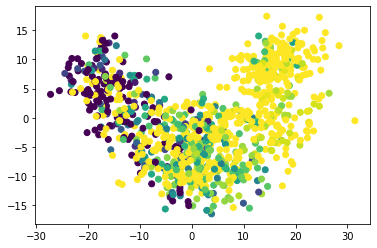

In [175]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=tiklova_PSI.loc['Cltb_2'])

In [91]:
v[0]

array([0.03445141, 0.04270655, 0.03748422, ..., 0.8059024 , 0.97597846,
       0.9823973 ])

In [18]:
plt.scatter(tiklova_rd.PC_1, tiklova_rd.PC_2, c=v1, cmap='bwr', vmin=-1, vmax=1)

NameError: name 'v1' is not defined

In [46]:
calculate_cross_L(tiklova_PSI, W, tiklova_mrna_event, "Mapt_1", "Cadm1_10", c = 0.1, 
                      randomize = False, seed=0, min_probability = 0.01, sum_times=10, min_obs=0.25)

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars


(0.08482516511664967, 0.2375191335278806)

In [37]:
calculate_cross_L(tiklova_PSI, W, tiklova_mrna_event, "Mapt_1", "Cadm1_10", c = 0.1, 
                      randomize = False, seed=0, min_probability = 0.01, sum_times=10, min_obs=0.25)

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars


(0.23101966161169232, 0.8349629682715706)

In [43]:
calculate_cross_L(tiklova_PSI, W, tiklova_mrna_event, "Rpn2_3", "Cadm1_10", c = 0.1, 
                      randomize = False, seed=0, min_probability = 0.01, sum_times=10, min_obs=0.25)

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars


(2.7836427428881723, 1.8522181213892033)

In [45]:
calculate_cross_L(tiklova_PSI, W, tiklova_mrna_event, "Rpn2_3", "Cadm1_10", c = 0.1, 
                      randomize = False, seed=0, min_probability = 0.01, sum_times=10, min_obs=0.25)

/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars
/mnt/lareaulab/cfbuenabadn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars


(2.7882380866138, 1.8382528711278514)

In [28]:
from scipy.special import expit
from scipy.special import logit
import numpy as np
from functools import partial
import pandas as pd
import time as t
from multiprocessing import Pool
from tqdm import tqdm
import seaborn as sns
from scipy.stats import zscore
from scipy.special import logit
from scipy.special import comb
import scipy.integrate as integrate
import scipy.special as special
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle


# from scipy.stats import binom
# from scipy.stats import beta
from scipy.stats import poisson

### For psix; the difference from verum is that is uses a gaussian kernel for the averages

def probability_psi_observation(psi_o, psi, c, r, sum_times=10):
    '''
    Calculate P(observed_PSI | true_PSI, capture efficiency, captured molecules)
    
    Input:
      psi_o (float): observed PSI
      psi (float): underlying PSI
      c (float): capture efficiency
      r (int): caputured gene mRNA molecules
      
    Output:
      P(psi_o | psi, c, r)
    
    '''
    m_array = np.arange(r, np.int(sum_times*r/c))
    
    comb_1 = comb(m_array*psi, r*psi_o)
    comb_2 = comb(m_array*(1-psi), r*(1-psi_o))
    proba_1 = c**(r+1)
    proba_2 = (1-c)**(m_array-r)
    
    prob_array = comb_1*comb_2*proba_1*proba_2
    
    return np.sum(prob_array)


# def probability_psi_approx(psi_o, psi, c, r, approximate=30):
#     m_array = poisson.rvs(r/c, size=approximate)
#     m_array = np.array([r if x < r else x for x in m_array])
#     proba = prob_psi_m_known(psi_o, psi, r, m_array)
#     return np.mean(proba)
    
def probability_psi_approx(psi_o, psi, c, r):
    m = r/c
    if (m*psi < r*psi_o) or (m*(1-psi) < r*(1-psi_o)):
        proba = probability_psi_observation(psi_o, psi, c, r)
    else:
        proba = prob_psi_m_known(psi_o, psi, r, m)
    return proba
    
def prob_psi_m_known(psi_o, psi, r, m):
    comb_1 = comb(m*psi, r*psi_o)
    comb_2 = comb(m*(1-psi), r*(1-psi_o))
    comb_3 = comb(m, r)**(-1)
    return comb_1*comb_2*comb_3


def L_observation(psi_o, psi_a, psi_null, r, c, min_probability, sum_times):
    
    
    L_a = np.max([min_probability, probability_psi_approx(psi_o, psi_a, c, r)])
    L_null = np.max([min_probability, probability_psi_approx(psi_o, psi_null, c, r)])
    
    L_a = np.log(L_a)
    L_null = np.log(L_null)
        
#     L_a = np.log10(L_a)
#     L_null = np.log10(L_null)
        
    if (np.isnan(L_a) or np.isnan(L_null) or np.isnan(L_a - L_null)):
        L = 0
    else:
        L = L_a - L_null
    return L


def L_statistic_vec(psi_o_array, psi_a_array, psi_null, mrna_array, c, min_probability, sum_times):
    L = []
    psi_a_array = np.array([0.99 if x > 0.99 else 0.01 if x < 0.01 else x for x in psi_a_array])

    func = lambda i: L_observation(psi_o_array[i], psi_a_array[i], psi_null, mrna_array[i], c, min_probability, sum_times)
    x = range(len(psi_o_array))
    x_func = np.vectorize(func)
    L = x_func(x)

    return L
    
    
def calculate_exon_L(PSI_tab, W, mrna_counts, exon, k = 0, c = 0.1, weight_distance=True, randomize = False, seed=0, min_probability = 0.01, sum_times=10):
    

    try:
        cell_list = PSI_tab.loc[exon].dropna().index

        if randomize:
            np.random.seed(seed)
            shuffled_cells = shuffle(cell_list)

        else:
            shuffled_cells = cell_list

        psi_o_array = np.array(PSI_tab.loc[exon, shuffled_cells])

        mrna_array = np.array([1 if ((x > 0.1) and (x <= 1)) else x for x in mrna_counts.loc[exon,  shuffled_cells]])
        mrna_array = np.round(mrna_array).astype(int)

        total_cells = round((len(cell_list) - np.sum(mrna_array == 0)))

        if total_cells <= 0:
            return np.nan

        psi_a_array = np.array(
        np.array(pd.DataFrame(
            np.array(W.loc[cell_list, cell_list])*psi_o_array).sum(axis=1)
        )/np.array(W.loc[cell_list, cell_list].sum(axis=1)))

        psi_null = np.mean(psi_o_array)

        L_vec = L_statistic_vec(psi_o_array, psi_a_array, psi_null, mrna_array, c, min_probability, sum_times)

        ######
        return np.sum(L_vec)/total_cells

    except:
        print('error')
        return np.nan
    
    
# def calculate_cross_L(PSI_tab, W, mrna_counts, exon1, exon2, k = 0, c = 0.1, weight_distance=True, randomize = False, seed=0, min_probability = 0.01, sum_times=10, min_obs=0.25, aproximate = 0):
    
#     try:

#         cell_list1 = PSI_tab.loc[exon1].dropna().index
#         cell_list2 = PSI_tab.loc[exon2].dropna().index

#         cell_list = cell_list1 & cell_list2

#         if len(cell_list)/len(PSI_tab.columns) < min_obs:
#             return np.nan, np.nan


#         psi_o_array_1 = np.array(PSI_tab.loc[exon1, cell_list])
#         psi_o_array_2 = np.array(PSI_tab.loc[exon2, cell_list])

#         mrna_array_1 = np.array([1 if ((x > 0.1) and (x <= 1)) else x for x in mrna_counts.loc[exon1,  cell_list]])
#         mrna_array_1 = np.round(mrna_array_1).astype(int)

#         mrna_array_2 = np.array([1 if ((x > 0.1) and (x <= 1)) else x for x in mrna_counts.loc[exon2,  cell_list]])
#         mrna_array_2 = np.round(mrna_array_2).astype(int)

#         total_cells_1 = round((len(cell_list) - np.sum(mrna_array_1 == 0)))
#         total_cells_2 = round((len(cell_list) - np.sum(mrna_array_2 == 0)))

#         if (total_cells_1 <= 0) or (total_cells_2 <= 0):
#             return np.nan, np.nan

#         psi_a_array_1 = np.array(
#         np.array(pd.DataFrame(
#             np.array(W.loc[cell_list, cell_list])*psi_o_array_1).sum(axis=1)
#         )/np.array(W.loc[cell_list, cell_list].sum(axis=1)))

#         psi_null_1 = np.mean(psi_o_array_1)


#         psi_a_array_2 = np.array(
#         np.array(pd.DataFrame(
#             np.array(W.loc[cell_list, cell_list])*psi_o_array_2).sum(axis=1)
#         )/np.array(W.loc[cell_list, cell_list].sum(axis=1)))

#         psi_null_2 = np.mean(psi_o_array_2)

#         L_vec_1 = L_statistic_vec(psi_o_array_1, psi_a_array_2, psi_null_2, mrna_array_1, c, min_probability, sum_times, aproximate)
#         L_vec_2 = L_statistic_vec(psi_o_array_2, psi_a_array_1, psi_null_1, mrna_array_2, c, min_probability, sum_times, aproximate)

#         ######
#         return np.sum(L_vec_1)/total_cells_1, np.sum(L_vec_2)/total_cells_2

#     except:
# #         print('error')
#         return np.nan, np.nan
    
    
def get_distance_matrix(pca, k=100):
    print('Changed to natural log')
    nbrs = NearestNeighbors(n_neighbors=k).fit(pca)
    distances, indices = nbrs.kneighbors(pca)
    
    cells = list(pca.index)
    
    W = pd.DataFrame(np.zeros((len(cells), len(cells))))
    W.columns = cells
    W.index = cells
    
    for i in tqdm(range(len(cells))):
        cell_i = cells[i]
        sigma = np.max(distances[i])
        for j in range(1, len(distances[i])):
            cell_j = cells[indices[i][j]]
            d = distances[i][j]
            w = np.exp(-(d**2)/(sigma**2))        
            W.loc[cell_i, cell_j] = w
    
    return W

